## Loading the IMBD movie review dataset as the training dataset

In [3]:
!pip install tensorflow
!pip install keras_bert

In [1]:
import pandas as pd
import numpy as np
import csv
import numpy as np
pretrained_path = './BERT-mini'

In [2]:
from keras_bert import extract_embeddings

## Load Training Dataset
### Transform into embeddings 

In [30]:
# Trainpath = 'drive/MyDrive/Sentiment/project/IMDB_Dataset.xlsx'

# df_dataset = pd.read_excel(Trainpath)
# train_data = df_dataset['review'][:10000]
# train_label = df_dataset['sentiment'][:10000]
# for i in range(10000):
#     train_label[i] = 1 if train_label[i] == "positive" else -1

In [31]:
# y_train = []
# x_train = []
# embeddings = extract_embeddings(pretrained_path, train_data)
# for index in range(10000):
#     x_train.append(embeddings[index][0]) 
#     y_train.append(train_label[index])

# nowfile = open('drive/MyDrive/Sentiment/project/miniData.txt', 'w')
# for i in range(10000):
#     nowfile.write(str(y_train[i]))
#     for j in range(len(x_train[i])):
#         nowfile.write(' ' + str(x_train[i][j]))
#     nowfile.write('\n')
# nowfile.close()

### Loading Embeddings
Have been saved to the miniData.txt

In [4]:
def read_input_data(path):
    x = []
    y = []
    for line in open(path).readlines():
        items = line.strip().split(' ')
        tempX = []
        for i in range(1, len(items)): tempX.append(float(items[i]))
        x.append(tempX)
        y.append(float(items[0]))
    return np.array(x), np.array(y)

In [6]:
#training set embeddings
TrainingPath = "./miniData.txt"
x_train, y_train = read_input_data(TrainingPath)
print(x_train.shape)
print(y_train)

(10000, 256)
[ 1.  1.  1. ... -1. -1.  1.]


### Done the training process on colab

In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

param_dist = {'C': loguniform(1e-2, 1e3),
 'gamma': loguniform(1e-4, 1e-3),
 'kernel': ['rbf'],
 'class_weight':['balanced', None]}

n_iter_search = 10

first_model = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_iter=n_iter_search)
first_model.fit(x_train,y_train)
print('Best score for training data:', first_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',first_model.best_estimator_.C,"\n") 
print('Best Kernel:',first_model.best_estimator_.kernel,"\n")
print('Best Gamma:',first_model.best_estimator_.gamma,"\n")

Best score for training data: 0.7968000000000001 

Best C: 302.6763085558697 

Best Kernel: rbf 

Best Gamma: 0.0007698579387315076 



In [37]:
import joblib
# choose first_model
joblib.dump(first_model, 'drive/MyDrive/Sentiment/project/BERTModel-mini')

['drive/MyDrive/Sentiment/project/BERTModel-mini']

In [38]:
task_model = joblib.load('drive/MyDrive/Sentiment/project//BERTModel-mini')

## Using the model to predict YouTube review

In [7]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")
import yt_helper

In [10]:
!pip install dill

In [11]:
import joblib
task_model = joblib.load('./BERTModel-mini')

C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.0.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [12]:
def yt_comment_preprocess(df, limit):
    processed_dataset = yt_helper.comment.preprocessing(df=df, emoji_to_word=True) 
    test_data = processed_dataset['regular_text']
    
    embeddings_test = extract_embeddings(pretrained_path, test_data)
    x_test = []
    for i in range(limit):
        x_test.append(embeddings_test[i][0])
        
    return x_test

In [13]:
def predict_result(youtubeID):
    SORT_BY_POPULAR = 1
    SORT_BY_RECENT = 0

    limit = 200 # set to None to download all comments
    sort = SORT_BY_POPULAR
    output = None  # do not write out files

    df = yt_helper.comment.fetch(youtubeID=youtubeID, limit=limit,
                                                language='en', sort=sort, output=output)

    x_test = yt_comment_preprocess(df, limit)
    y_pred = task_model.predict(x_test)
    positive_rate = (y_pred >= 0.5).sum() / y_pred.shape[0]
    nagative_rate = (y_pred < 0.5).sum() / y_pred.shape[0]
    return positive_rate, nagative_rate

In [14]:
youtubeID = 'OscqgBj1HCw'
predict_result(youtubeID)

Downloaded 200 comment(s)
[6.96 seconds] Done!


C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(0.795, 0.205)

## Evaluating the performance of choosen model
### Load Testing Dataset

In [15]:
df_test = pd.read_csv('./output.csv')

In [22]:
x_test = []

df_test = df_test[df_test['label'] != 0]
df_test['label'] = df_test['label'].apply(lambda x: -1 if x < 0 else x)
test_data = df_test['comment']
y_test = df_test['label']

embeddings_test = extract_embeddings(pretrained_path, test_data)
for i in range(200):
    x_test.append(embeddings_test[i][0])

print(len(y_test))
print(len(embeddings_test))

200
200


In [23]:
from sklearn import metrics

y_pred = task_model.predict(x_test)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.58      0.46      0.52        54
           1       0.82      0.88      0.84       146

    accuracy                           0.77       200
   macro avg       0.70      0.67      0.68       200
weighted avg       0.75      0.77      0.76       200



In [19]:
positive_rate = (y_pred >= 0.5).sum() / y_pred.shape[0]
nagative_rate = (y_pred < 0.5).sum() / y_pred.shape[0]
print('positive_rate:', positive_rate,', nagative_rate:', nagative_rate)

positive_rate: 0.785 , nagative_rate: 0.215


In [20]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("roc_auc:", roc_auc)

roc_auc: 0.6698376458650431


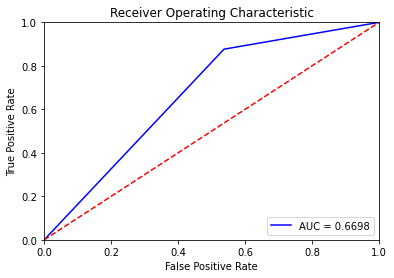

In [21]:
import matplotlib.pyplot as plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()